## Mount dataset resources

In [1]:
import re
import pandas as pd
import numpy as np
import warnings

import datetime
from datetime import datetime, date
import time

# Visualisation
from matplotlib import pyplot as plt

# Suppress warnings
warnings.filterwarnings("ignore")

# чтениие/запись файлов в feather-формате
import feather

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
%cd '/content/drive/MyDrive/github/eda_examples/automobile_data/'
%pwd

/content/drive/MyDrive/github/eda_examples/automobile_data


'/content/drive/MyDrive/github/eda_examples/automobile_data'

## Predictive Modeling of car prices
<br>

#### Data Description

Этот набор данных состоит из трех типов сущностей:
- Спецификация авто по разным характеристикам.
- присвоенный ему рейтинг страхового риска: (-3, -2, -1, 0, 1, 2, 3).
- Нормализованные потери в эксплуатации по сравнению с другими автомобилями: нормализованные потери от 65 до 256.

Второй рейтинг соответствует тому, насколько автомобиль более рискован, чем указывает его цена. Автомобилям изначально присваивается ID фактора риска, связанный с его ценой. Затем, если это более рискованно (или менее), этот ID корректируется, перемещая его вверх или вниз по шкале. Актуарии называют этот процесс «символизацией». Значение +3 указывает на то, что авто рискованно, -3, что, вероятно, довольно безопасно.

Третий фактор - это относительная средняя сумма компенсации за ущерб на год застрахованного автомобиля. Это значение нормализовано для всех автомобилей в пределах определенной классификации (двухдверные малолитражки, универсалы, спортивные / специализированные автомобили и т. Д.) И представляет собой средние потери на автомобиль в год.

#### Class Attributes
 
- make: alfa-romero, audi, bmw, chevrolet, dodge, honda, isuzu, jaguar, mazda, mercedes-benz, mercury, mitsubishi, nissan, peugot, plymouth, porsche, renault, saab, subaru, toyota, volkswagen, volvo 
- fuel-type: diesel, gas. 
- aspiration: std, turbo. 
- num-of-doors: four, two. 
- body-style: hardtop, wagon, sedan, hatchback, convertible. 
- drive-wheels: 4wd, fwd, rwd. 
- engine-location: front, rear. 
- engine-type: dohc, dohcv, l, ohc, ohcf, ohcv, rotor. 
- num-of-cylinders: eight, five, four, six, three, twelve, two. 
- fuel-system: 1bbl, 2bbl, 4bbl, idi, mfi, mpfi, spdi, spfi. 

### I. Exploratory Data Analysis

В этом разделе мы исследуем данные, анализируем и обрабатываем недостающие значения, а затем корреляционный анализ.

In [74]:
# loading packages
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization and missing values
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs
import missingno as msno # missing values
%matplotlib inline

# stats
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_squared_error, r2_score

# machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
seed = 123

# importing data ( ? = missing values)
data = pd.read_csv("Auto-Data.csv", na_values = '?')
data.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-type',
       'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke',
       'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
       'highway-mpg', 'price'],
      dtype='object')

In [75]:
data.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

In [76]:
# first glance at the data itself
print("In total: ",data.shape)
data.head(5).append(data.tail(5))

In total:  (205, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0
200,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,23,28,16845.0
201,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160.0,5300.0,19,25,19045.0
202,-1,95.0,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134.0,5500.0,18,23,21485.0
203,-1,95.0,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106.0,4800.0,26,27,22470.0
204,-1,95.0,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3062,ohc,four,141,mpfi,3.78,3.15,9.5,114.0,5400.0,19,25,22625.0


Датасет достаточно маленький: 205 наблюдений, 26 признаков.

In [77]:
data.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,164.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,201.000000,201.000000,205.000000,203.000000,203.000000,205.000000,205.000000,201.000000
mean,0.834146,122.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329751,3.255423,10.142537,104.256158,5125.369458,25.219512,30.751220,13207.129353
std,1.245307,35.442168,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273539,0.316717,3.972040,39.714369,479.334560,6.542142,6.886443,7947.066342
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,150.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


##### Табл. выше указывает на след. важные выводы 

- Большинство распределений переменных имеют смещение (skewed).
- Имеем различные единицы измерения.
- Есть пропуски в данных.

### - Missing Values

В этом разделе мы рассмотрим пропущенные значения.

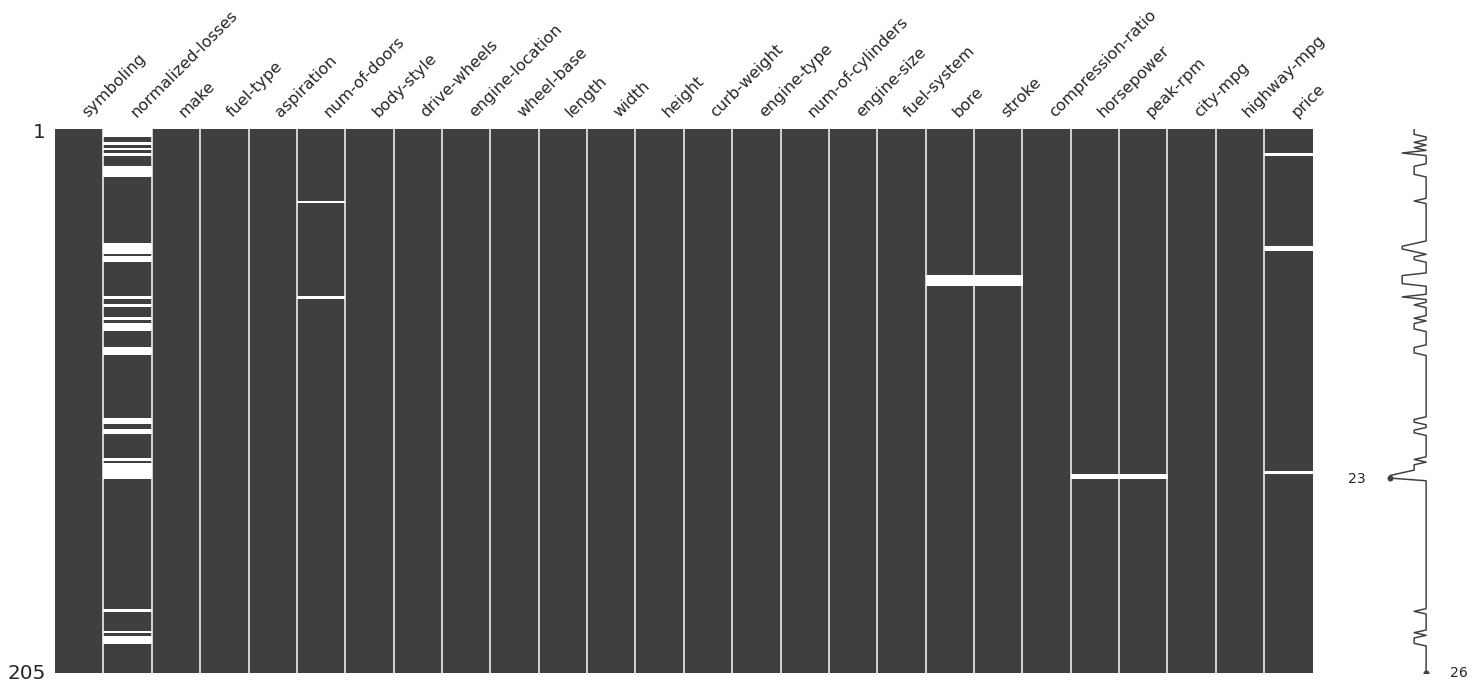

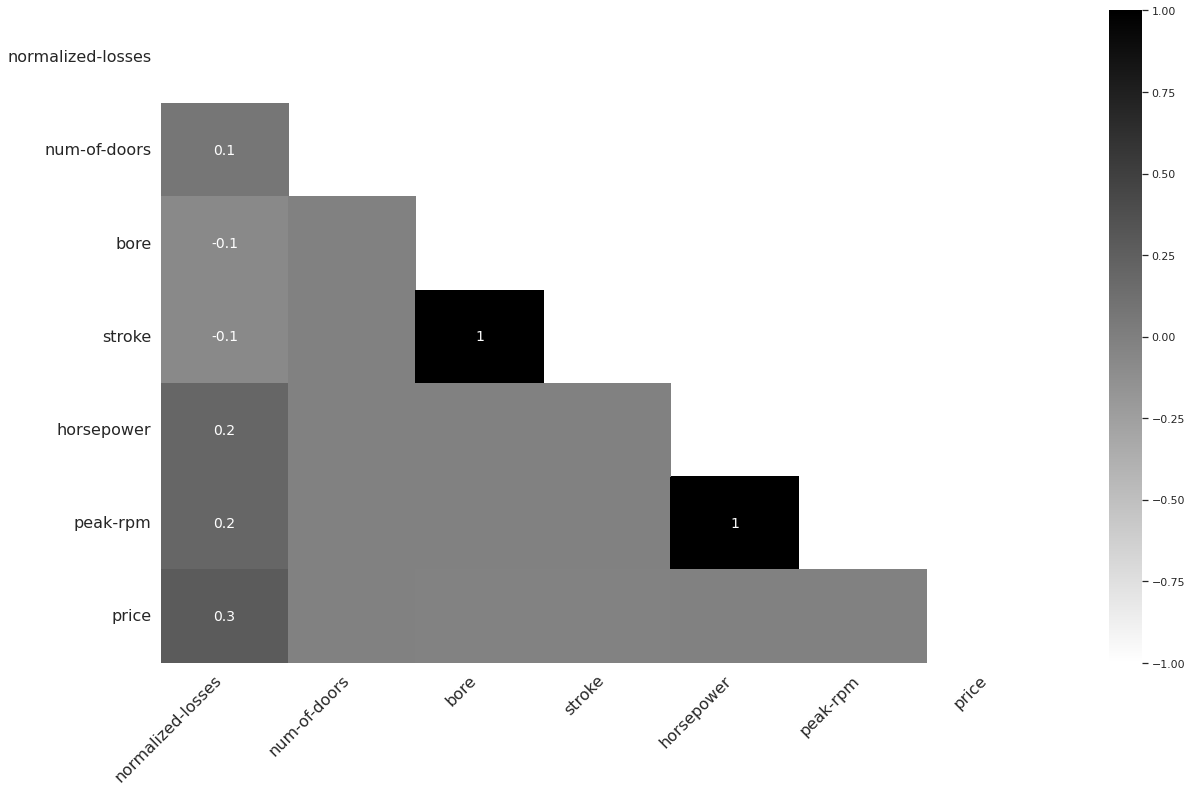

In [78]:
# missing values?
sns.set(style = "ticks")

msno.matrix(data)
msno.heatmap(data, cmap = 'binary')

набор данных более-менее чистый со случайными пропущенными значениями. Однако нам следует уделять больше внимания переменной `normalized-losses`, поскольку кажется, что первая может быть коррелирована с целевой переменной `price`.

Две пары переменных, таких как `bore` и `strike`, `horsepower` и `peak-rpm`, сильно коррелируют друг с другом посредством "nullity pattern".


### - Replacement by grouped medians

PS: они представляют собой средние потери на автомобиль в год.

In [79]:
# missing values in normalied-losses
data[pd.isnull(data['normalized-losses'])].head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0


Мы не видим здесь каких-либо конкретных nullity patterns. Однако мы можем заметить, что все четыре пропущенных значения переменной `price` соответствуют нормированным потерям NaN.

В связи с тем, что недостающих цен всего четыре, мы можем смело отбрасывать их для дальнейшего анализа. Другой подход необходим для `normalized-losses`.


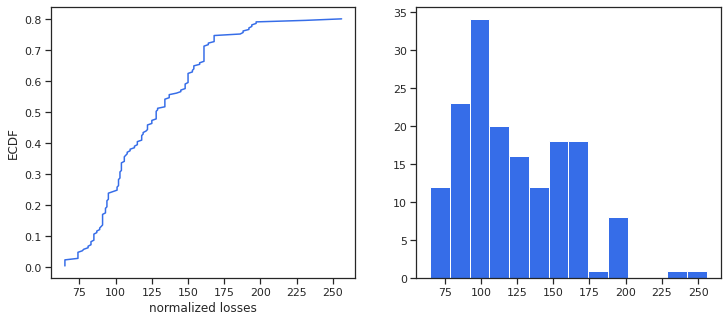

In [80]:
sns.set(style = "ticks")
plt.figure(figsize = (12, 5)) 
c = '#366DE8'

# ECDF
plt.subplot(121)
cdf = ECDF(data['normalized-losses'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('normalized losses'); plt.ylabel('ECDF');

# overall distribution
plt.subplot(122)
plt.hist(data['normalized-losses'].dropna(), 
         bins = int(np.sqrt(len(data['normalized-losses']))),
         color = c);

Мы видим, что __80% нормированных потерь ниже 200__ и примерно половина из них ниже 125.

Мы могли бы просто заменить NaN на медианные значения переменной, вместо этого мы подходим к этому несколько иначе. Мы знаем, что эти __ убытки связаны со страховкой__ каждого автомобиля, которая, в свою очередь, зависит от переменной риска `symboling`. Поэтому вместо того, чтобы заменять NaN на общую медиану, мы __заменяем их средними значениями групп__.

Давайте сначала посмотрим на средние значения:


In [81]:
data.groupby('symboling')['normalized-losses'].describe()

,count,mean,std,min,25%,50%,75%,max
symboling,,,,,,,,
-2,3.0,103.000000,0.000000,103.0,103.00,103.0,103.0,103.0
-1,20.0,85.600000,18.528499,65.0,71.75,91.5,95.0,137.0
0,48.0,113.166667,32.510773,77.0,91.00,102.0,120.5,192.0
1,47.0,128.574468,28.478630,74.0,105.50,125.0,148.0,231.0
2,29.0,125.689655,30.167513,83.0,94.00,134.0,137.0,192.0
3,17.0,168.647059,30.636867,142.0,150.00,150.0,194.0,256.0


In [82]:
# replacing
data = data.dropna(subset = ['price', 'bore', 'stroke', 'peak-rpm', 'horsepower', 'num-of-doors'])
data['normalized-losses'] = data.groupby('symboling')['normalized-losses'].transform(lambda x: x.fillna(x.mean()))

print('In total:', data.shape)
data.head()

In total: (193, 26)


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,174.384615,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,174.384615,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,128.152174,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.000000,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.000000,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


Теперь гораздо лучше. Выборка данных уменьшилась с 205 до 193, что не имеет большого значения.

Давайте также посмотрим на целевую переменную `price`:


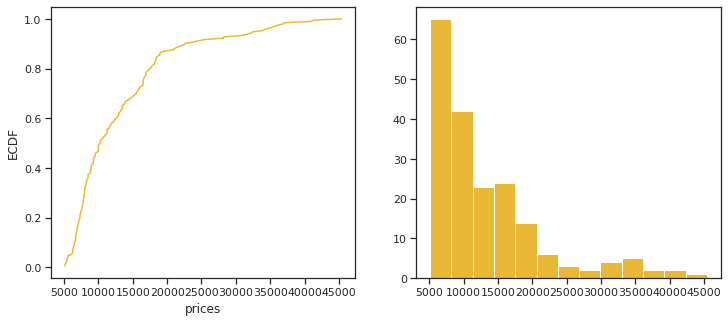

In [83]:
plt.figure(figsize = (12, 5)) 
c2 = '#E8B836'

# ECDF
plt.subplot(121)
cdf = ECDF(data['price'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c2);
plt.xlabel('prices'); plt.ylabel('ECDF');

# overall distribution
plt.subplot(122)
plt.hist(data['price'], 
         bins = int(np.sqrt(len(data['price']))),
         color = c2);

Распределение `price` __скошено вправо__ с большим количеством наблюдений в левой части графика. Можно сделать вывод, что __большая часть цен на автомобили, около 80%, выше 18'000$__.


### - Feature selection and correlations

Перед кодированием классов в числовые значения мы можем отбросить несколько сильно коррелированных с целевыми переменными. Мы делаем это, чтобы избежать больших весов элементов при построении модели.

Однако выбор данных (отбрасывание функций) можно рассматривать как не лучший подход. Возможно, здесь PCA может иметь больше смысла, но это для дальнейшего исследования.


In [84]:
def mosthighlycorrelated(mydataframe, numtoreport):
    # find the correlations
    cormatrix = mydataframe.corr()
    # set the correlations on the diagonal or lower triangle to zero,
    # so they will not be reported as the highest ones:
    cormatrix *= np.tri(*cormatrix.values.shape, k=-1).T
    # find the top n correlations
    cormatrix = cormatrix.stack()
    cormatrix = cormatrix.reindex(cormatrix.abs().sort_values(ascending=False).index).reset_index()
    # assign human-friendly names
    cormatrix.columns = ["FirstVariable", "SecondVariable", "Correlation"]
    return cormatrix.head(numtoreport)

mosthighlycorrelated(data, 10)

,FirstVariable,SecondVariable,Correlation
0,city-mpg,highway-mpg,0.971975
1,engine-size,price,0.888778
2,length,curb-weight,0.882694
3,wheel-base,length,0.879307
4,width,curb-weight,0.867640
5,length,width,0.857368
6,curb-weight,engine-size,0.857188
7,engine-size,horsepower,0.845325
8,curb-weight,price,0.835368
9,horsepower,city-mpg,-0.833615


Похоже, что __`city_mpg` и `highway-mpg` несут одну и ту же информацию__. Мы также видим, что __`engine-size` и `curb-weight`__ сильно коррелируют с целевой переменной `price`, что __ может привести к несбалансированной подгонке модели__. Размерность переменных  __`length`, `width` и` height`, вероятно, могут быть преобразованы__ в одну переменную `volume`, равную<br> 
$ length * height * width $.


In [85]:
data['volume'] = data.length * data.width * data.height

data.drop(['width', 'length', 'height', 'engine-size',
           'curb-weight', 'city-mpg'], 
          axis = 1, # 1 for columns
          inplace = True) 

In [86]:
# new variables
data.columns

Index(['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration',
       'num-of-doors', 'body-style', 'drive-wheels', 'engine-location',
       'wheel-base', 'engine-type', 'num-of-cylinders', 'fuel-system', 'bore',
       'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'highway-mpg',
       'price', 'volume'],
      dtype='object')

Давайте посмотрим на `price` и переменную, которые коррелируют с целевой переменной:

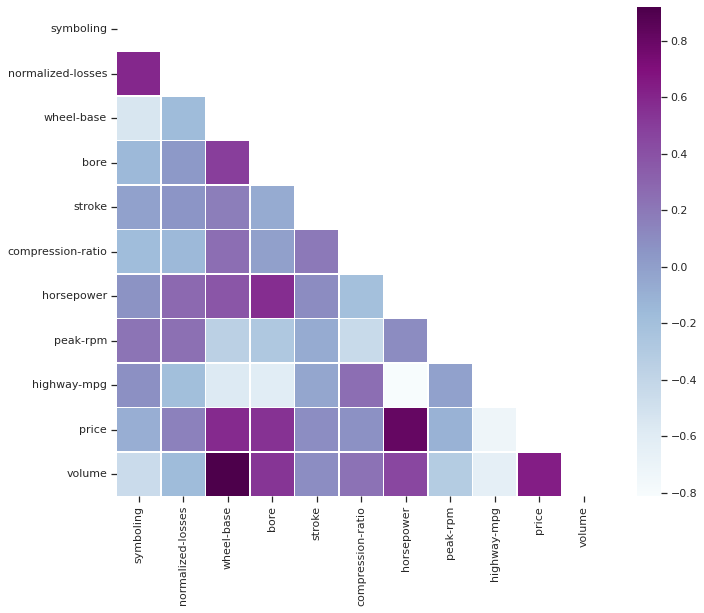

In [87]:
# Compute the correlation matrix 
corr_all = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize = (11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all, mask = mask,
            square = True, linewidths = .5, ax = ax, cmap = "BuPu")      
plt.show()

Похоже, что `price` имеет сильную положительную (линейную) корреляцию с переменными `wheel-base`, `bore` и `horsepower`.

Если бы мы построили график разброса для каждой непрерывной переменной в наборе данных относительно друг друга, мы бы увидели следующее:

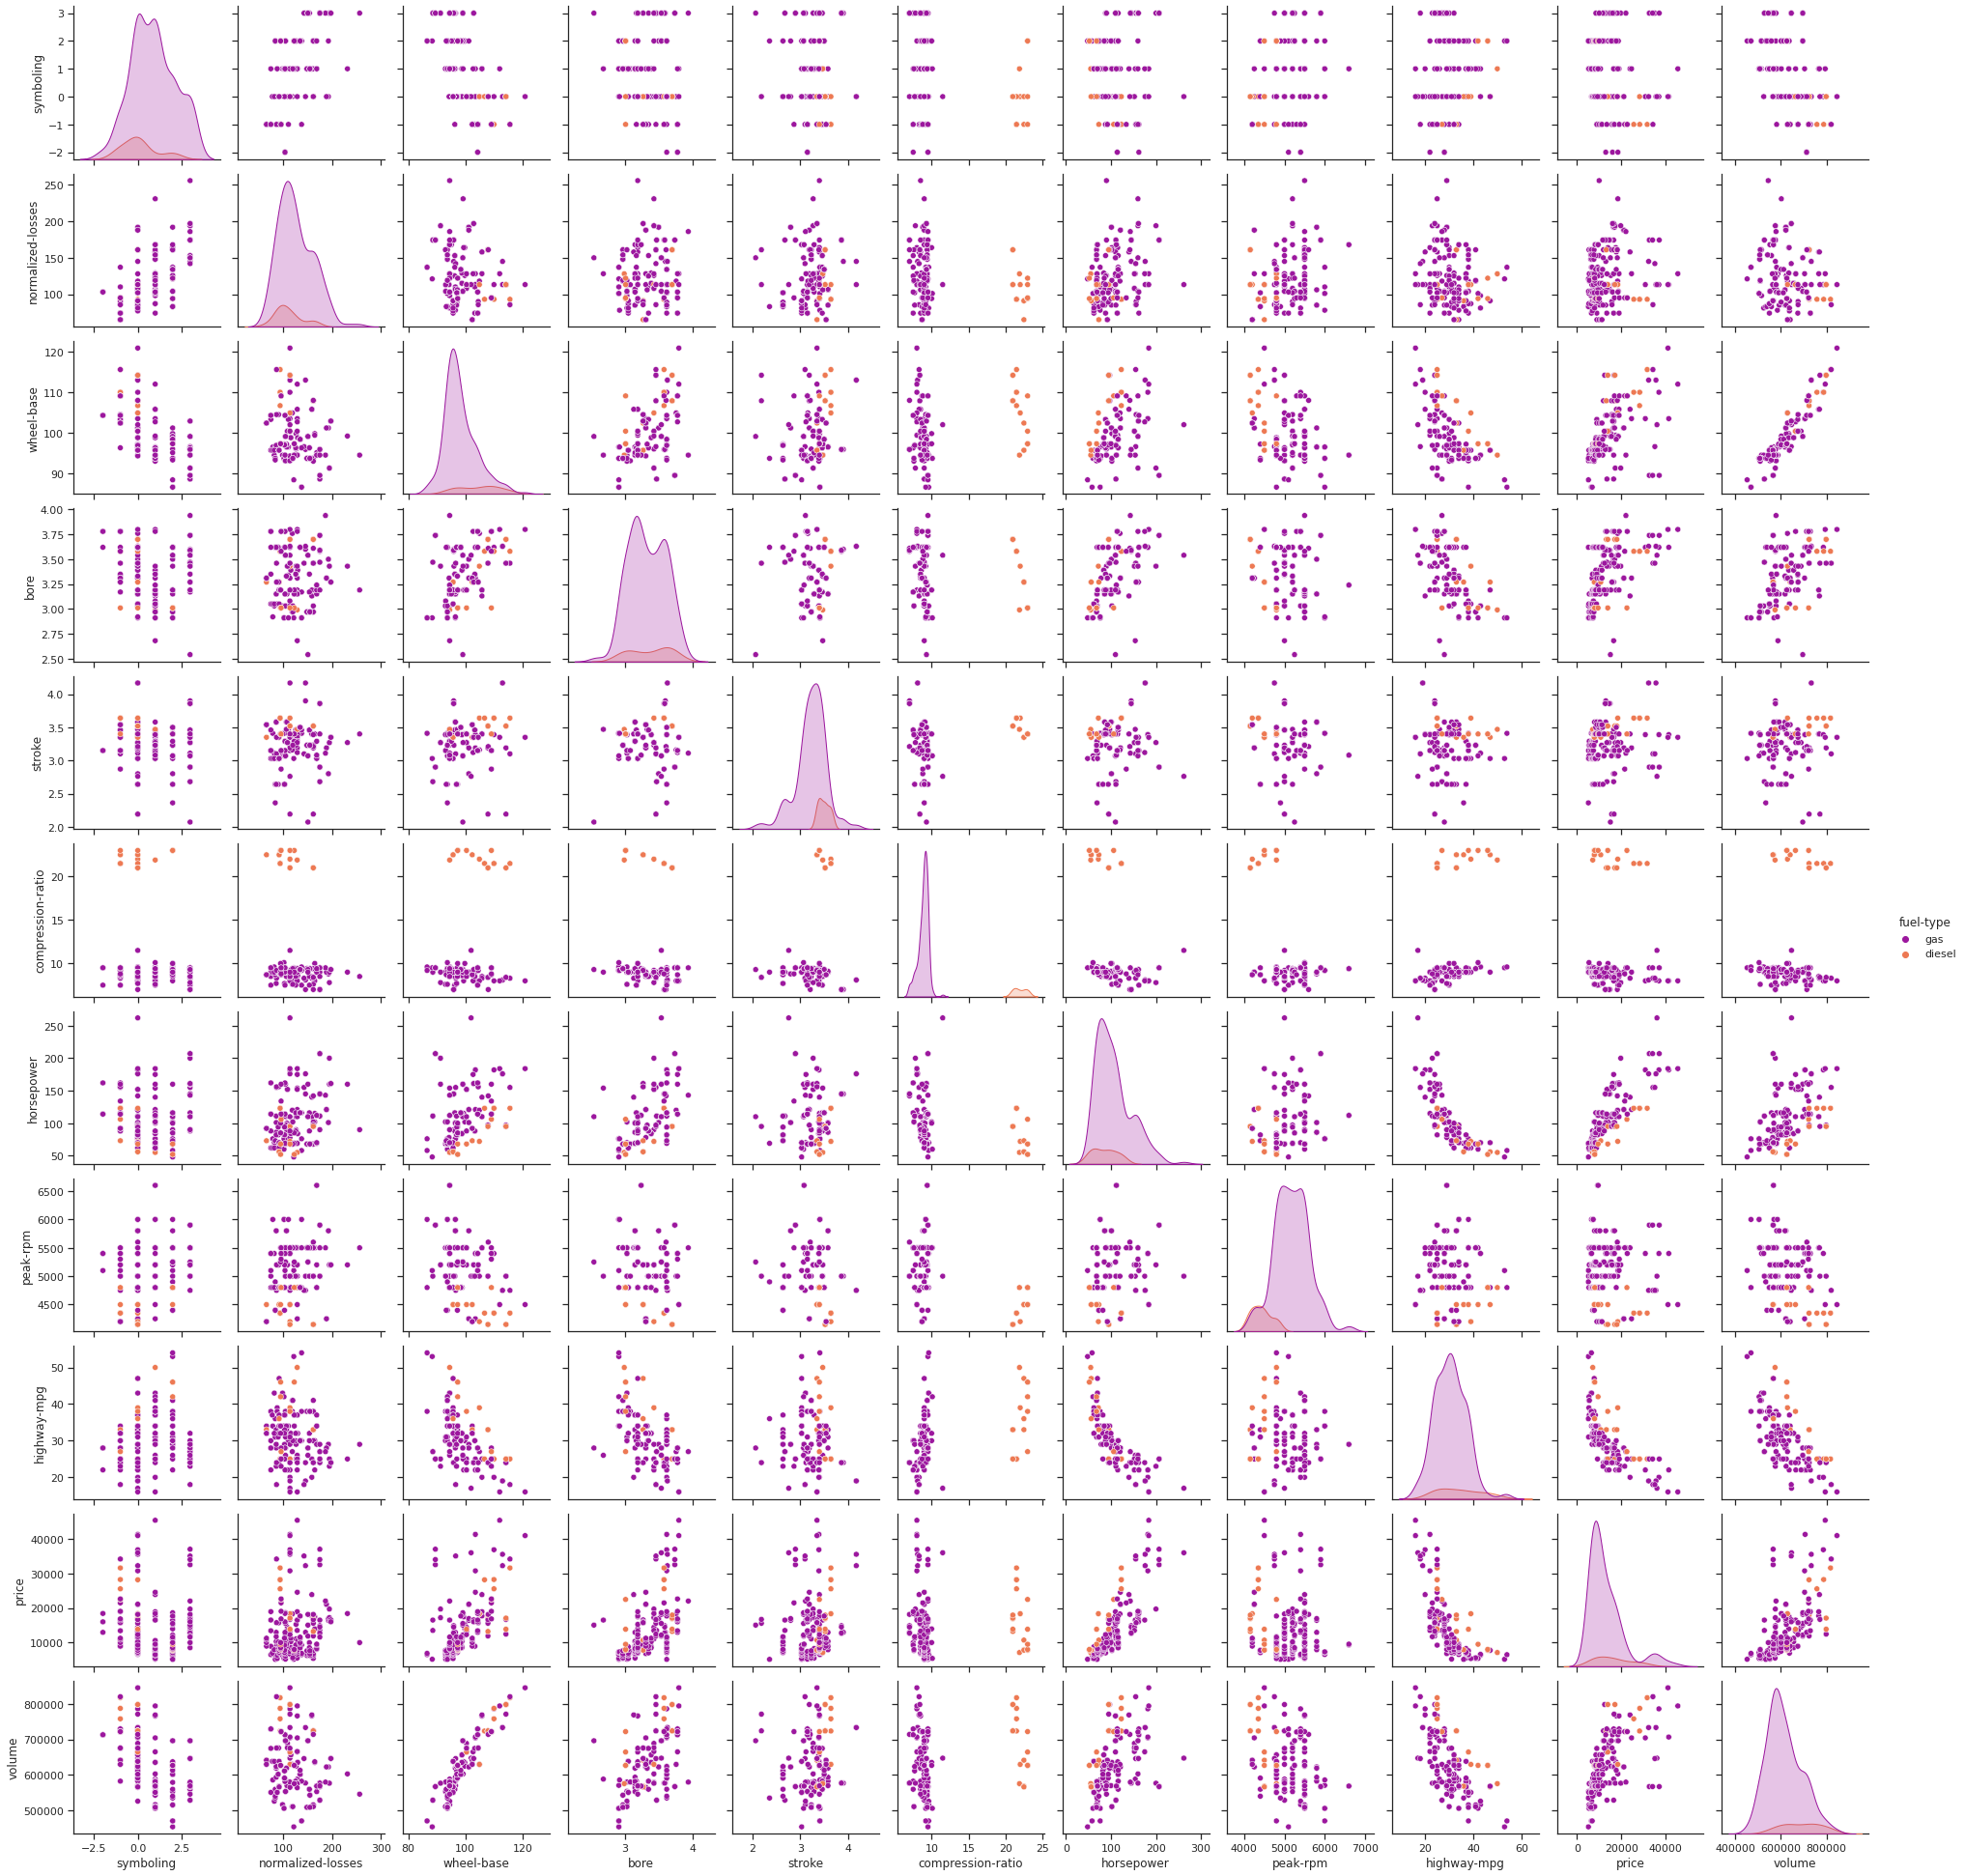

In [88]:
sns.pairplot(data, hue = 'fuel-type', palette = 'plasma');

График выше не только показывает текущие тенденции в наборе данных, но также показывает форму каждого (непрерывного) распределения. Некоторые из них напоминают «колоколообразную кривую», например `highway-mpg`, в то время как другие сильно скошены.

Мы также можем видеть __сформированные кластеры для `compression-ratio`__ на основе `fuel-type`.

Из любопытства давайте более подробно рассмотрим взаимосвязь между переменными `price` и `horsepower`.

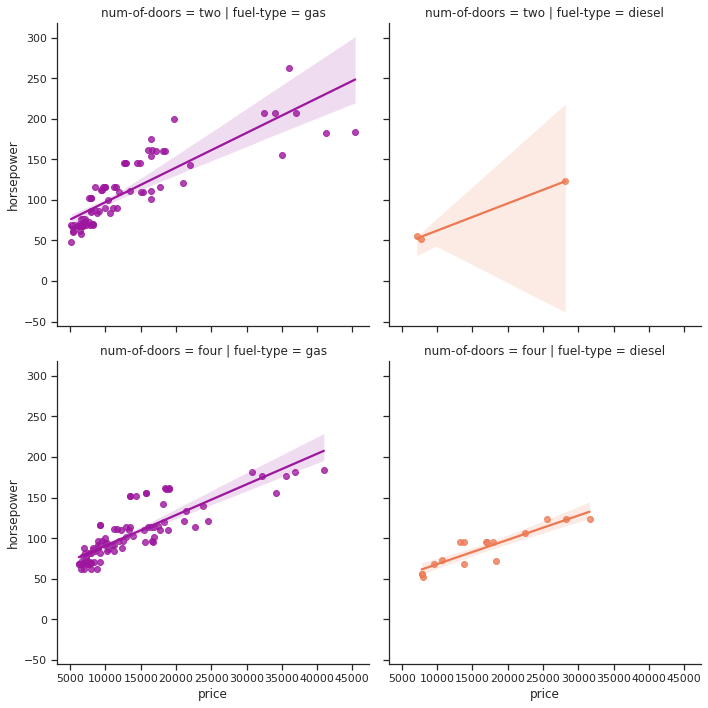

In [89]:
sns.lmplot('price', 'horsepower', data, 
           hue = 'fuel-type', col = 'fuel-type',  row = 'num-of-doors', 
           palette = 'plasma', 
           fit_reg = True);

Действительно, для каждого уровня переменных `fuel-type` и `num-of-doors` мы видим, что<br> __увеличение мощности автомобиля связано с пропорциональным увеличением его цены__.


### II. Predictive Modeling

В этом разделе мы сравниваем две разные регрессионные модели. Их выбор был существенно основан на размере выборки данных, технике регуляризации (для L1) и надежности алгоритма.

__Lasso Regression__

Эта модель решает задачу регрессии, где функция потерь является линейной функцией наименьших квадратов, а регуляризация задается l1-нормой. Выбор этой модели был сделан на основе количества измерений в данных: __у нас есть много признаков, которые, вероятно, будут нулевыми__.

__Random Forest Regression__

Регрессор случайного леса соответствует ряду деревьев классификационных решений для различных подвыборок набора данных и использует усреднение для повышения точности прогнозов и контроля чрезмерной подгонки за счет уменьшения общей дисперсии. Это один из самых популярных алгоритмов машинного обучения, широко используемый сообществом.


### - Preprocessing

Если у одного признака дисперсия намного больше, чем у других, он может доминировать над целевой функцией и сделать оценщик неспособным правильно учиться на других признаках. Вот почему нам нужно сначала масштабировать данные.


In [90]:
# target and features
target = data.price

regressors = [x for x in data.columns if x not in ['price']]
features = data.loc[:, regressors]

num = ['symboling', 'normalized-losses', 'volume', 'horsepower', 'wheel-base',
       'bore', 'stroke','compression-ratio', 'peak-rpm']

# scale the data
standard_scaler = StandardScaler()
features[num] = standard_scaler.fit_transform(features[num])

# glimpse
features.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,engine-type,num-of-cylinders,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,highway-mpg,volume
0,1.78685,1.477685,alfa-romero,gas,std,two,convertible,rwd,front,-1.682379,dohc,four,mpfi,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,-1.168294
1,1.78685,1.477685,alfa-romero,gas,std,two,convertible,rwd,front,-1.682379,dohc,four,mpfi,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,-1.168294
2,0.16397,0.144710,alfa-romero,gas,std,two,hatchback,rwd,front,-0.720911,ohcv,six,mpfi,-2.394827,0.702918,-0.288273,1.334283,-0.213359,26,-0.422041
3,0.97541,1.178276,audi,gas,std,four,sedan,fwd,front,0.142781,ohc,four,mpfi,-0.517605,0.480415,-0.036204,-0.039139,0.856208,30,0.169527
4,0.97541,1.178276,audi,gas,std,four,sedan,4wd,front,0.077596,ohc,five,mpfi,-0.517605,0.480415,-0.540341,0.304217,0.856208,22,0.193551


### - Feature Encoding

Чтобы использовать категориальные переменные в обучении модели, нам нужно __закодировать их в dummies__.


In [91]:
# categorical vars
classes = ['make', 'fuel-type', 'aspiration', 'num-of-doors', 
           'body-style', 'drive-wheels', 'engine-location',
           'engine-type', 'num-of-cylinders', 'fuel-system']

# create new dataset with only continios vars 
dummies = pd.get_dummies(features[classes])
features = features.join(dummies).drop(classes, 
                                       axis = 1)

# new dataset
print('In total:', features.shape)
features.head()

In total: (193, 65)


,symboling,normalized-losses,wheel-base,bore,stroke,compression-ratio,horsepower,peak-rpm,highway-mpg,volume,make_alfa-romero,make_audi,make_bmw,make_chevrolet,make_dodge,make_honda,make_isuzu,make_jaguar,make_mazda,make_mercedes-benz,make_mercury,make_mitsubishi,make_nissan,make_peugot,make_plymouth,make_porsche,make_saab,make_subaru,make_toyota,make_volkswagen,make_volvo,fuel-type_diesel,fuel-type_gas,aspiration_std,aspiration_turbo,num-of-doors_four,num-of-doors_two,body-style_convertible,body-style_hardtop,body-style_hatchback,body-style_sedan,body-style_wagon,drive-wheels_4wd,drive-wheels_fwd,drive-wheels_rwd,engine-location_front,engine-location_rear,engine-type_dohc,engine-type_l,engine-type_ohc,engine-type_ohcf,engine-type_ohcv,num-of-cylinders_eight,num-of-cylinders_five,num-of-cylinders_four,num-of-cylinders_six,num-of-cylinders_three,num-of-cylinders_twelve,fuel-system_1bbl,fuel-system_2bbl,fuel-system_idi,fuel-system_mfi,fuel-system_mpfi,fuel-system_spdi,fuel-system_spfi
0,1.78685,1.477685,-1.682379,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,-1.168294,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1.78685,1.477685,-1.682379,0.513027,-1.808186,-0.288273,0.198569,-0.213359,27,-1.168294,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0.16397,0.144710,-0.720911,-2.394827,0.702918,-0.288273,1.334283,-0.213359,26,-0.422041,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0
3,0.97541,1.178276,0.142781,-0.517605,0.480415,-0.036204,-0.039139,0.856208,30,0.169527,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
4,0.97541,1.178276,0.077596,-0.517605,0.480415,-0.540341,0.304217,0.856208,22,0.193551,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [92]:
# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                    test_size = 0.3,
                                                    random_state = seed)
print("Train", X_train.shape, "and test", X_test.shape)

Train (135, 65) and test (58, 65)


### - Lasso

Как обычно, мы используем перекрестную проверку (cross validation), чтобы уменьшить чрезмерную подгонку и обобщить невидимые данные.


CV results: 0.8268971716355628 225.757779668547


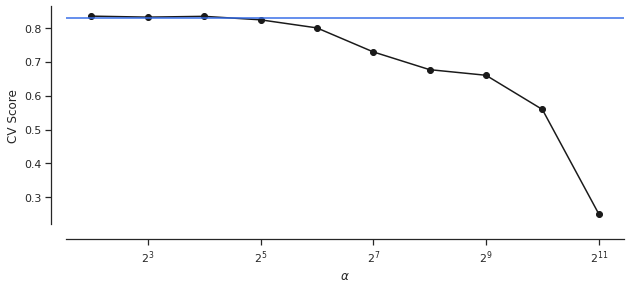

In [93]:
# logarithmic scale: log base 2
# high values to zero-out more variables
alphas = 2. ** np.arange(2, 12)
scores = np.empty_like(alphas)

for i, a in enumerate(alphas):
    lasso = Lasso(random_state = seed)
    lasso.set_params(alpha = a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)
    
lassocv = LassoCV(cv = 10, random_state = seed)
lassocv.fit(features, target)
lassocv_score = lassocv.score(features, target)
lassocv_alpha = lassocv.alpha_

plt.figure(figsize = (10, 4))
plt.plot(alphas, scores, '-ko')
plt.axhline(lassocv_score, color = c)
plt.xlabel(r'$\alpha$')
plt.ylabel('CV Score')
plt.xscale('log', basex = 2)
sns.despine(offset = 15)

print('CV results:', lassocv_score, lassocv_alpha)

Это уже хороший результат: R2 = 0,82.<br>
Давайте рассмотрим особенности модели.


Lasso picked 13 features and eliminated the other 52 features.


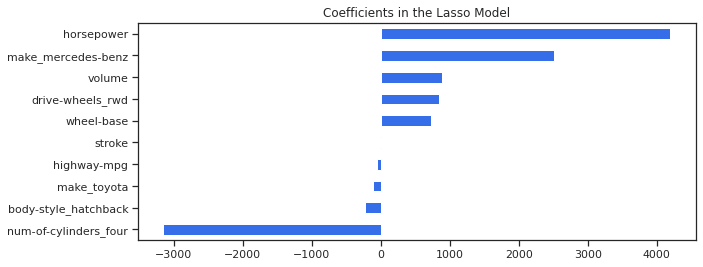

In [94]:
# lassocv coefficients
coefs = pd.Series(lassocv.coef_, index = features.columns)

# prints out the number of picked/eliminated features
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features.")

# takes first and last 10
coefs = pd.concat([coefs.sort_values().head(5), coefs.sort_values().tail(5)])

plt.figure(figsize = (10, 4))
coefs.plot(kind = "barh", color = c)
plt.title("Coefficients in the Lasso Model")
plt.show()

In [95]:
model_l1 = LassoCV(alphas = alphas, cv = 10, random_state = seed).fit(X_train, y_train)
y_pred_l1 = model_l1.predict(X_test)

model_l1.score(X_test, y_test)

0.8330744522624414

Мы получаем более высокий score при тестировании, чем на train-наборе, что показывает, что модель, вероятно, имеет хорошую способность __к обобщению на неизвестных данных__.

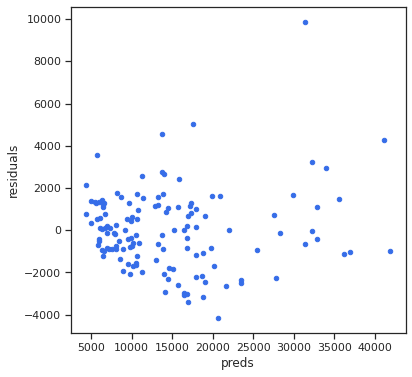

In [96]:
# residual plot
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds": model_l1.predict(X_train), "true": y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals", kind = "scatter", color = c)

График выглядит более или менее хорошо: в левом нижнем углу графика есть агрегирование остатков, поэтому модель может быть в определенной степени смещена (biased) на несколько градусов, но не особенно сильно.


In [97]:
def MSE(y_true,y_pred):
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: %2.3f' % mse)
    return mse

def R2(y_true,y_pred):    
    r2 = r2_score(y_true, y_pred)
    print('R2: %2.3f' % r2)     
    return r2

MSE(y_test, y_pred_l1); R2(y_test, y_pred_l1);

MSE: 3870543.789
R2: 0.833


In [98]:
# predictions
d = {'true' : list(y_test),
     'predicted' : pd.Series(y_pred_l1)
    }

pd.DataFrame(d).head()

,true,predicted
0,8499.0,8698.454622
1,17450.0,16848.107734
2,9279.0,11050.616354
3,7975.0,10177.257093
4,6692.0,6505.098638


Мы видим, что значения не так уж и велики, но, безусловно, есть возможности для улучшения.

### - Random Forest Regressor

- `n_estimators`: количество деревьев, которые нужно построить перед максимальным голосованием или усреднением прогнозов. Большее количество деревьев дает лучшую производительность. В данном случае мы берем __`n_estimators = 1000`__.

- `max_features`: количество признаков, которые следует учитывать при поиске лучшего прогноза. Мы уже знаем, что процент __ релевантных признаков составляет от 10 до 20%__, поэтому мы берем этот диапазон.

- `min_samples_leaf`: параметр сильно зависит от размера выборки. Мы оставим его по умолчанию 2.

- `max_depth`: максимальная глубина дерева также зависит от размера выборки. Больше данных - больше глубина. Здесь, напротив, у нас довольно маленький набор данных, поэтому __range от 5 до 10 с шагом 1__ будет достаточно.


In [99]:
%%time

from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor(n_estimators = 1000, random_state = seed)

param_grid = {'max_depth': list(range(5, 10, 1)),
              'max_features': [0.05, 0.1, 0.15, 0.2]}

grid_search = GridSearchCV(rfr, param_grid, 
                           n_jobs = -1, # no restriction on processor usage
                           cv = 5) # 5 fold cv
grid_search.fit(X_train, y_train)

print('Best combination:', grid_search.best_params_);

print('\nTime elapsed:')

Best combination: {'max_depth': 9, 'max_features': 0.1}

Time elapsed:
CPU times: user 2.41 s, sys: 117 ms, total: 2.53 s
Wall time: 1min 54s


In [100]:
%%time

# with best parameters for 1000 estimators
rfr = RandomForestRegressor(max_features = 0.1, max_depth = 9, 
                            n_estimators = 1000, random_state = seed)

score_train = cross_val_score(rfr, X_train, y_train, cv = 5).mean()
score_test = cross_val_score(rfr, X_test, y_test, cv = 5).mean()

print("Score with the train set = %.2f" % score_train)

print('\nTime elapsed:')

Score with the train set = 0.87

Time elapsed:
CPU times: user 13 s, sys: 83.3 ms, total: 13.1 s
Wall time: 13.1 s


In [101]:
%%time
model_rfr = rfr.fit(X_train, y_train)

# predictions
y_pred_rf = model_rfr.predict(X_test)

d = {'true' : list(y_test),
     'predicted' : pd.Series(y_pred_rf)
    }

pd.DataFrame(d).head()

CPU times: user 1.4 s, sys: 12.7 ms, total: 1.41 s
Wall time: 1.41 s


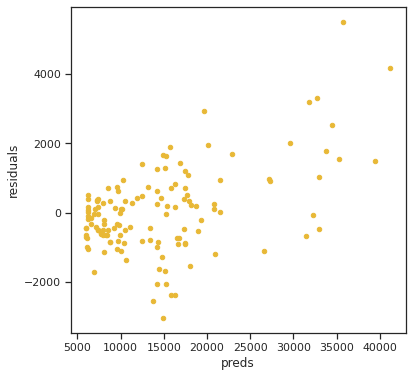

In [102]:
# residual plot
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds_rf= pd.DataFrame({"preds": model_rf.predict(X_train), "true": y_train})
preds_rf["residuals"] = preds_rf["true"] - preds_rf["preds"]
preds_rf.plot(x = "preds", y = "residuals", kind = "scatter", color = c2)

Практически идентичный график. Также распечатаем метрики `MSE` и `R2`:


In [103]:
MSE(y_test, y_pred_rf); R2(y_test, y_pred_rf);

MSE: 3520669.812
R2: 0.848


В целом Random Forest показал немного лучшую эффективность по обоим показателям. Посмотрим, какие особенности способствуют результату:

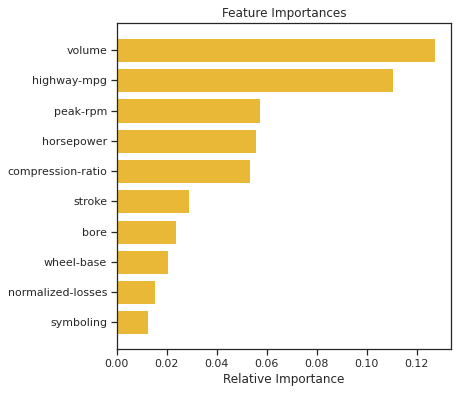

In [104]:
# first ten importances 
importances = model_rf.feature_importances_[:10]
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color = c2, align = 'center')
plt.yticks(range(len(indices)), features)
plt.xlabel('Relative Importance')
plt.show()

Список наиболее важных признаков остается более или менее одинаковым для обеих моделей: `horsepower` и `volume`. Тем не менее, __Random Forest считает `volume` и `highway-mpg` наиболее важными признаками с относительной важностью 0,14 и 0,12 соответственно__. Между тем, Лассо выбрал `volume` в качестве третьей фичи и `highway-mpg` в качестве десятой.

### Summary

- Мы проанализировали данные, построив ECDF и распределения.
- Пропущенные значения в `normalized-losses` заменялись на сгруппированные медианы.
- Визуализированы и перечислены сильно коррелированные признаки.
- Произведен выбор и преобразование данных.
- Предварительно обработаны данные и закодированы классы.
- Подходящая регрессия L1 и случайный лес для моделей регрессии с использованием перекрестной проверки и поиска по сетке.
- Сравнение показателей MSE и R2 для обеих моделей.
- Построены графики остатков и значений важности признаков.


### Final Thoughts and the Room for improvement

Мы достигли неплохих результатов для обеих моделей:
- Лассо с `MSE=3870543` и `R2=0,83`.
- Random Forest: `MSE=3443289` и `R2=0,85`.

Очевидно, что __при наличии большего кол-ва данных обе модели показали бы лучшую эффективность__. Что касается предварительной обработки, можно использовать другой подход для преобразования данных - __Principal Component Analysis__, который использует ортогональное преобразование для преобразования набора наблюдений возможно коррелированных переменных в набор значений, __формирующих новые комбинированные признаки__.

Дополнительные данные PCA можно подогнать к модели регрессии __XGboost__, которая идеально подходит для средних и больших наборов данных и также широко используется в Kaggle.

Наконец, мы могли бы также выполнить __stacked обобщение на базовых моделях из этой записной книжки__, используя прогнозы как из входных данных, так и из истинных значений в качестве выходных.

[datageekette](datageekette.com)